In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e8096cf628d499589a26d1ef1f4a173e02247e40ecb5c4f67d319b7238d639bd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
!pip install six

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
from scipy.signal import savgol_filter

import scipy.sparse
import umap

from six.moves import xrange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid


#a) Advantages of VQ-VAE over VAE:


Variational Autoencoders (VAEs) and Vector Quantized Variational Autoencoders (VQ-VAEs) are both types of generative models used in machine learning, particularly in the domain of unsupervised learning and generative modeling. here are some advantageous of VQ-VAE compared to traditional VAEs:

1) Discrete Latent Space:

One of the primary differences lies in the nature of the latent space. While VAEs use continuous latent spaces, VQ-VAEs use discrete latent spaces. This can be beneficial in scenarios where a discrete representation is more suitable for capturing certain characteristics or features of the data.

2) Improved Representations:

VQ-VAEs are designed to produce more structured and interpretable representations in the discrete latent space. This can lead to better disentanglement of factors of variation in the data, making it easier to understand and control specific aspects of the generated samples.


3) Robustness to Variational Collapse:

VAEs are known to suffer from an issue called "posterior collapse," where the encoder ignores the input data and produces similar latent codes for different inputs. VQ-VAEs are less prone to this issue, providing more stable and diverse representations.


4) Explicit Codebook:

VQ-VAEs use an explicit codebook, containing a set of discrete vectors, to quantize the continuous latent space. This allows for a more straightforward understanding of the learned representations and facilitates better control over the generation process.


5) Improved Sample Quality:

The discrete nature of the latent space in VQ-VAEs can result in improved sample quality, as it helps the model focus on capturing specific features more effectively. This can be particularly useful in applications where generating high-quality samples is crucial.


6) Reduced Mode Collapse:

VQ-VAEs can be more resistant to mode collapse, a common issue in generative models where the model generates only a limited set of diverse samples. The discrete latent space and explicit codebook in VQ-VAEs help mitigate this problem.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# b)

## Load Data

In [5]:
training_data = datasets.MNIST(root="data", train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (1.0,))
                                ]))


validation_data = datasets.MNIST(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (1.0,))
                                  ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 113426559.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40297968.67it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32822470.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3286273.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
batch_size = 256
train_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

val_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

# c)

## Vector Quantizer Layer


In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(inputs.shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized, perplexity, encodings


We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [8]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, quantized, perplexity, encodings


## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [9]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [10]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=1,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

# d)

# Training



In [12]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(1, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, codebook_vectors = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, codebook_vectors

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def train_model(model, train_loader, device, num_training_updates, learning_rate, data_variance, file_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = torch.nn.MSELoss()

    model.to(device)  # Move the model to the specified device

    model.train()
    ims = []
    costs = []

    for i in range(num_training_updates):
        (inputs, _) = next(iter(train_loader))
        inputs = inputs.to(device)

        optimizer.zero_grad()

        vq_loss, x_recon, perplexity, codebook = model(inputs)

        recon_loss = F.mse_loss(x_recon, inputs) / data_variance
        total_loss = recon_loss + vq_loss

        total_loss.backward()
        optimizer.step()

        costs.append(total_loss.item())

        if i % 100 == 0:
            print(f"Step: {i}, Recon Loss: {recon_loss.item()}, VQ Loss: {vq_loss.item()}, Perplexity: {perplexity.item()}")

        # Record the codebook vectors at this time step
        codebook_data = codebook.data.cpu().numpy()
        im = plt.scatter(codebook_data[:, 0], codebook_data[:, 1], cmap='viridis', c=np.arange(len(codebook_data)))
        ims.append([im])

    ani = animation.ArtistAnimation(plt.figure(), ims, interval=50, blit=True)
    ani.save(f'{file_name}.gif', writer='imagemagick', fps=5)
    plt.figure(figsize=(10, 5))
    plt.plot(costs, label='Total Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Cost Over Time')
    plt.grid(True)
    plt.show()


def save_codebook_gif(model, loader, device, num_training_updates, learning_rate, data_variance, file_name):
    model.train()
    ims = []

    def update_codebook_plot(frame, model, ims):
        plt.clf()  # Clear the previous plot
        (inputs, _) = next(iter(loader))
        inputs = inputs.to(device)
        vq_loss, x_recon, perplexity, codebook = model(inputs)

        # Record the codebook vectors at this time step
        codebook_data = codebook.data.cpu().numpy()
        im = plt.scatter(codebook_data[:, 0], codebook_data[:, 1], cmap='viridis', c=np.arange(len(codebook_data)))
        ims.append([im])

        return ims

    fig = plt.figure(figsize=(8, 8))
    ani = animation.FuncAnimation(fig, update_codebook_plot, frames=num_training_updates,
                                  fargs=(model, ims), blit=True)

    ani.save(f'{file_name}.gif', writer='imagemagick', fps=5)

    plt.close(fig)  # Close the figure after saving the animation
    plt.show()





def visualize_samples(model, data_loader, device, num_samples=5, plot_codebooks=False):
    model.eval()

    # Fetch some random samples
    sample_indices = np.random.choice(len(data_loader.dataset), num_samples, replace=False)
    samples = [data_loader.dataset[i][0].unsqueeze(0) for i in sample_indices]
    samples = torch.cat(samples, dim=0).to(device)

    # Forward pass
    with torch.no_grad():
        vq_loss, reconstructions, _, codebook = model(samples)

    # Move data back to CPU for visualization
    samples, reconstructions, codebook = (
        samples.cpu().numpy(),
        reconstructions.cpu().numpy(),
        codebook.cpu().numpy(),
    )

    # Plotting
    num_cols = 3 if plot_codebooks else 2
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(12, 3 * num_samples))

    for i in range(num_samples):
        # Ensure that pixel values are in the range [0, 1]
        input_image = np.clip(samples[i], 0, 1)
        reconstruction_image = np.clip(reconstructions[i], 0, 1)

        # Convert to uint8 for imshow
        input_image = (input_image * 255).astype(np.uint8)
        reconstruction_image = (reconstruction_image * 255).astype(np.uint8)

        axes[i, 0].imshow(input_image.transpose(1, 2, 0))
        axes[i, 0].set_title("Input")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(reconstruction_image.transpose(1, 2, 0))
        axes[i, 1].set_title("Reconstruction")
        axes[i, 1].axis("off")

        if plot_codebooks:
            axes[i, 2].scatter(
                codebook[:, 0], codebook[:, 1], cmap="viridis", c=np.arange(len(codebook))
            )
            axes[i, 2].set_title("Codebook")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# f) train model with three two dimentonal embeddings

In [14]:
batch_size = 256
num_training_updates = 1000
num_hiddens = 64
num_residual_hiddens = 16
num_residual_layers = 2
commitment_cost = 0.25
decay = 0.9
learning_rate = 1e-3
data_variance = np.var(training_data.data.numpy() / 255.0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step: 0, Recon Loss: 1.5447646379470825, VQ Loss: 0.08082522451877594, Perplexity: 1.0
Step: 100, Recon Loss: 0.7186924815177917, VQ Loss: 0.01632605865597725, Perplexity: 2.6316254138946533
Step: 200, Recon Loss: 0.3527602255344391, VQ Loss: 0.1384071707725525, Perplexity: 2.978623867034912
Step: 300, Recon Loss: 0.26712334156036377, VQ Loss: 0.13202504813671112, Perplexity: 2.9409193992614746
Step: 400, Recon Loss: 0.24803251028060913, VQ Loss: 0.13781461119651794, Perplexity: 2.9498984813690186
Step: 500, Recon Loss: 0.22461165487766266, VQ Loss: 0.12809492647647858, Perplexity: 2.932553768157959
Step: 600, Recon Loss: 0.21610808372497559, VQ Loss: 0.13073937594890594, Perplexity: 2.94291615486145
Step: 700, Recon Loss: 0.21406273543834686, VQ Loss: 0.1304910033941269, Perplexity: 2.9332613945007324
Step: 800, Recon Loss: 0.19433830678462982, VQ Loss: 0.12835706770420074, Perplexity: 2.9241323471069336
Step: 900, Recon Loss: 0.19528044760227203, VQ Loss: 0.1258692592382431, Perplexi

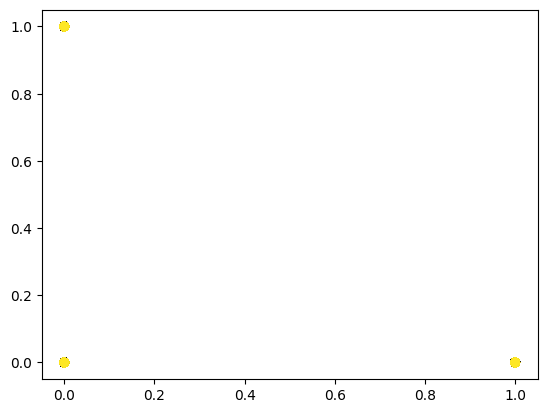

<Figure size 640x480 with 0 Axes>

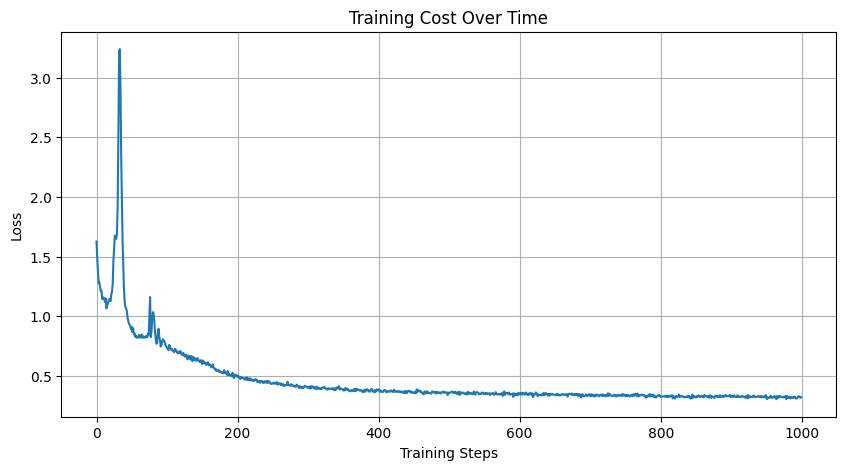

In [15]:
embedding_dim = 2
num_embeddings = 3
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay)
file_name = 'gif'
train_model(model, train_loader, device, num_training_updates, learning_rate, data_variance, file_name)

# g) Display inputs, outputs, codebook vectors

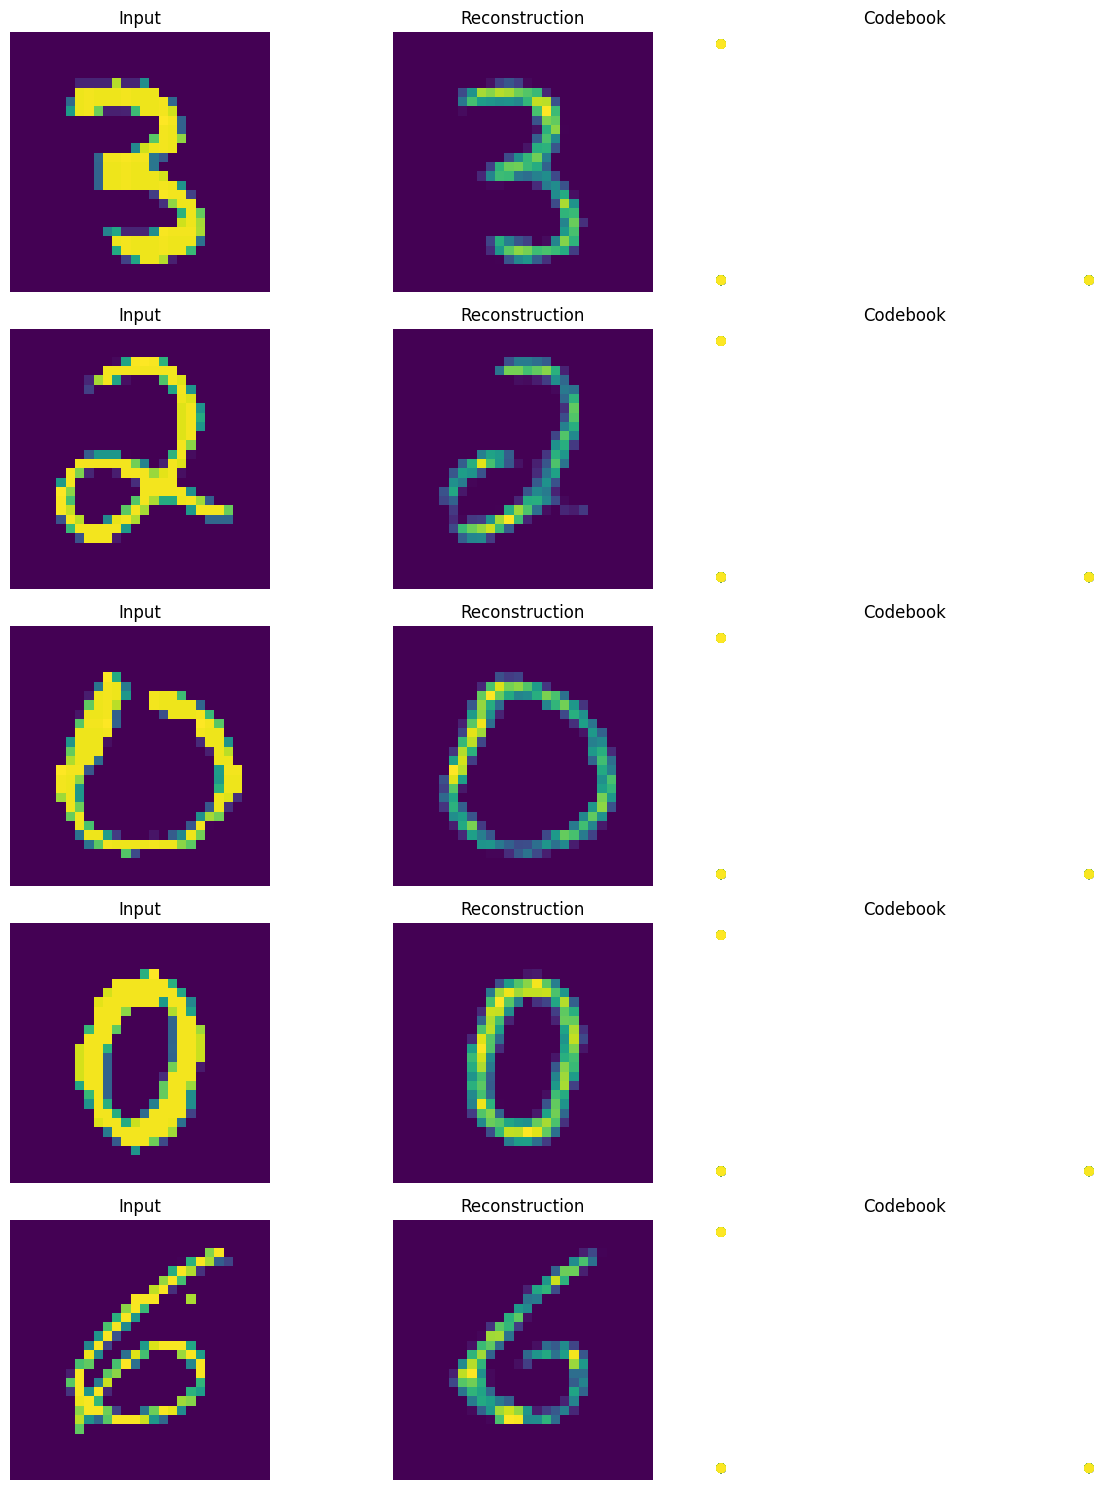

In [16]:
visualize_samples(model, val_loader, device, num_samples=5, plot_codebooks=True)

# h) make animation during training in step d

#i)

# 1) Create RGB MNIST Dataset

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Custom RGB Dataset class
class RGBDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        gray_image, label = self.mnist_dataset[idx]

        # Multiply each pixel by three random numbers
        color_channels = torch.rand(3, gray_image.size(1), gray_image.size(2))
        colored_image = gray_image * color_channels

        # Normalize values to be in the range [0, 1]
        colored_image = colored_image / colored_image.max()

        return colored_image, label

# rgb

In [18]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)


class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,  # Adjusted to handle RGB
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)



In [19]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()

        self._encoder = Encoder(3, num_hiddens,  # Adjusted to handle RGB
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                        num_hiddens,
                        num_residual_layers,
                        num_residual_hiddens)


    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, codebook_vectors = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, codebook_vectors


In [20]:
# Replace the existing data loading code with the RGB dataset
rgb_training_data = RGBDataset(training_data)
rgb_validation_data = RGBDataset(validation_data)

train_loader_rgb = DataLoader(rgb_training_data,
                               batch_size=batch_size,
                               shuffle=True,
                               pin_memory=True)

val_loader_rgb = DataLoader(rgb_validation_data,
                             batch_size=32,
                             shuffle=True,
                             pin_memory=True)


In [21]:
def train_model_rgb(model, train_loader, device, num_training_updates, learning_rate, data_variance, file_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = torch.nn.MSELoss()

    model.to(device)  # Move the model to the specified device

    model.train()
    ims = []
    costs = []

    for i in range(num_training_updates):
        (inputs, _) = next(iter(train_loader))
        inputs = inputs.to(device)

        optimizer.zero_grad()

        vq_loss, x_recon, perplexity, codebook = model(inputs)

        recon_loss = F.mse_loss(x_recon, inputs) / data_variance
        total_loss = recon_loss + vq_loss

        total_loss.backward()
        optimizer.step()

        costs.append(total_loss.item())

        if i % 100 == 0:
            print(f"Step: {i}, Recon Loss: {recon_loss.item()}, VQ Loss: {vq_loss.item()}, Perplexity: {perplexity.item()}")

        # Record the codebook vectors at this time step
        codebook_data = codebook.data.cpu().numpy()
        im = plt.scatter(codebook_data[:, 0], codebook_data[:, 1], cmap='viridis', c=np.arange(len(codebook_data)))
        ims.append([im])

    ani = animation.ArtistAnimation(plt.figure(), ims, interval=50, blit=True)
    ani.save(f'{file_name}.gif', writer='imagemagick', fps=5)
    plt.figure(figsize=(10, 5))
    plt.plot(costs, label='Total Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Cost Over Time')
    plt.grid(True)
    plt.show()


# 2) Increase the number of Codebooks

Step: 0, Recon Loss: 2.8526079654693604, VQ Loss: 0.2475729137659073, Perplexity: 2.2333219051361084
Step: 100, Recon Loss: 1.7226624488830566, VQ Loss: 0.029345709830522537, Perplexity: 2.871290445327759
Step: 200, Recon Loss: 1.6391265392303467, VQ Loss: 0.36674705147743225, Perplexity: 2.817556858062744
Step: 300, Recon Loss: 1.6126744747161865, VQ Loss: 0.8345146179199219, Perplexity: 2.9615471363067627
Step: 400, Recon Loss: 1.5455987453460693, VQ Loss: 0.6230437755584717, Perplexity: 2.9749865531921387
Step: 500, Recon Loss: 1.5129165649414062, VQ Loss: 0.8754270672798157, Perplexity: 2.9833459854125977
Step: 600, Recon Loss: 1.4977521896362305, VQ Loss: 1.1602932214736938, Perplexity: 2.989077091217041
Step: 700, Recon Loss: 1.4897946119308472, VQ Loss: 1.7072582244873047, Perplexity: 2.9946320056915283
Step: 800, Recon Loss: 1.454829216003418, VQ Loss: 1.3352417945861816, Perplexity: 2.9986770153045654
Step: 900, Recon Loss: 1.4385287761688232, VQ Loss: 1.6585097312927246, Perp

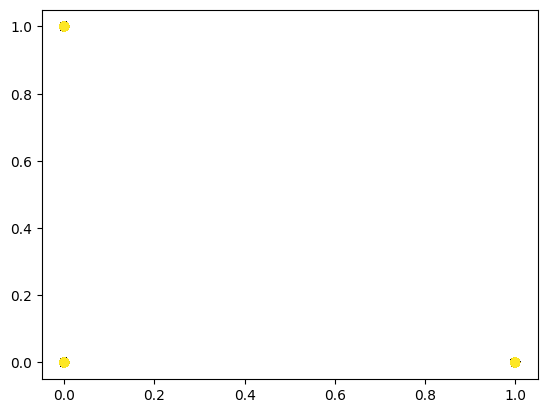

<Figure size 640x480 with 0 Axes>

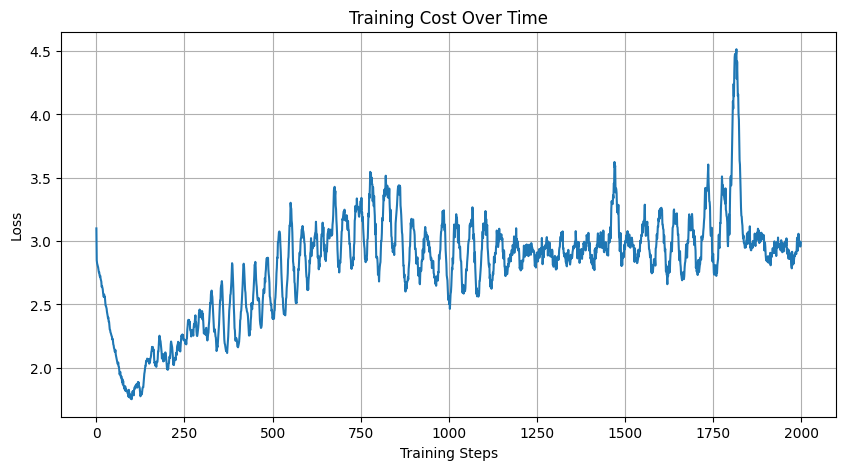

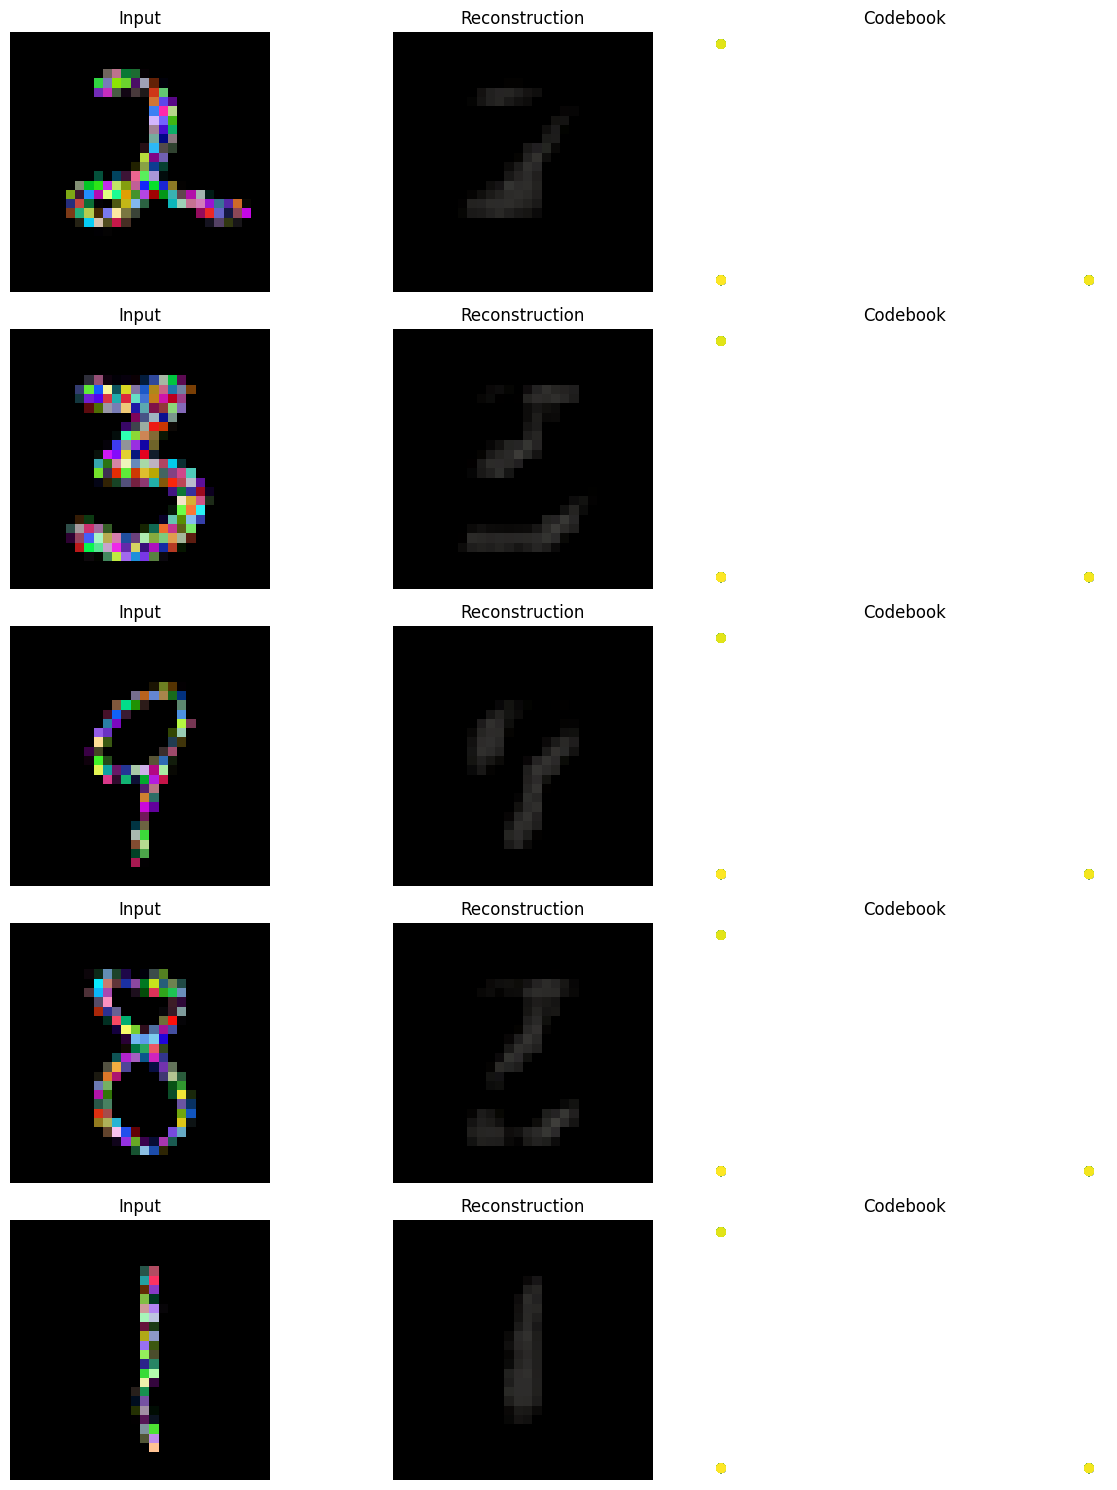

In [41]:
model1 = Model(num_hiddens=3, num_residual_layers=2, num_residual_hiddens=32, num_embeddings=3,
              embedding_dim=50, commitment_cost=0.25, decay=0.7)

file_name_rgb = 'gif_rgb1'
train_model_rgb(model1, train_loader_rgb, device, 2000, learning_rate, data_variance, file_name_rgb)

# Visualize samples for the RGB dataset
visualize_samples(model1, val_loader_rgb, device, num_samples=5, plot_codebooks=True)

# Conclusion: 

As we observe, increasing the number of the codebooks leads to a decrease in both the reconstruction loss and the vector quantization loss. Since there will be more vectors to map the encoding form and the information in the encoded form will be preserved better for decodeing process.

# 3) Increase the dimensionality of Codebooks

Step: 0, Recon Loss: 3.1980361938476562, VQ Loss: 0.013204186223447323, Perplexity: 2.2244009971618652
Step: 100, Recon Loss: 1.8394440412521362, VQ Loss: 0.006549853831529617, Perplexity: 33.3372917175293
Step: 200, Recon Loss: 1.5790681838989258, VQ Loss: 0.010149724781513214, Perplexity: 40.10774230957031
Step: 300, Recon Loss: 1.453059434890747, VQ Loss: 0.01105519663542509, Perplexity: 41.90986633300781
Step: 400, Recon Loss: 1.397133231163025, VQ Loss: 0.013849086128175259, Perplexity: 42.182830810546875
Step: 500, Recon Loss: 1.326738715171814, VQ Loss: 0.014935079962015152, Perplexity: 43.346256256103516
Step: 600, Recon Loss: 1.3187335729599, VQ Loss: 0.017053043469786644, Perplexity: 44.59576416015625
Step: 700, Recon Loss: 1.2771652936935425, VQ Loss: 0.018412481993436813, Perplexity: 42.08564376831055
Step: 800, Recon Loss: 1.2619762420654297, VQ Loss: 0.018933095037937164, Perplexity: 42.51272964477539
Step: 900, Recon Loss: 1.2581857442855835, VQ Loss: 0.01968623138964176

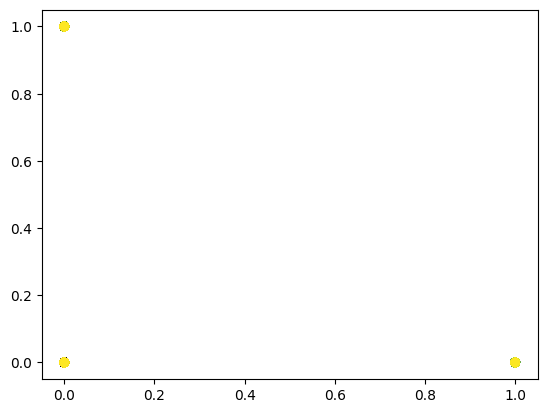

<Figure size 640x480 with 0 Axes>

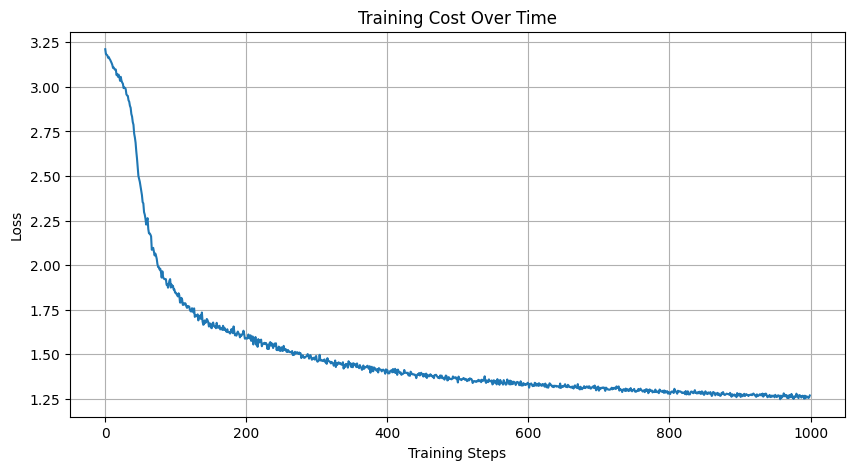

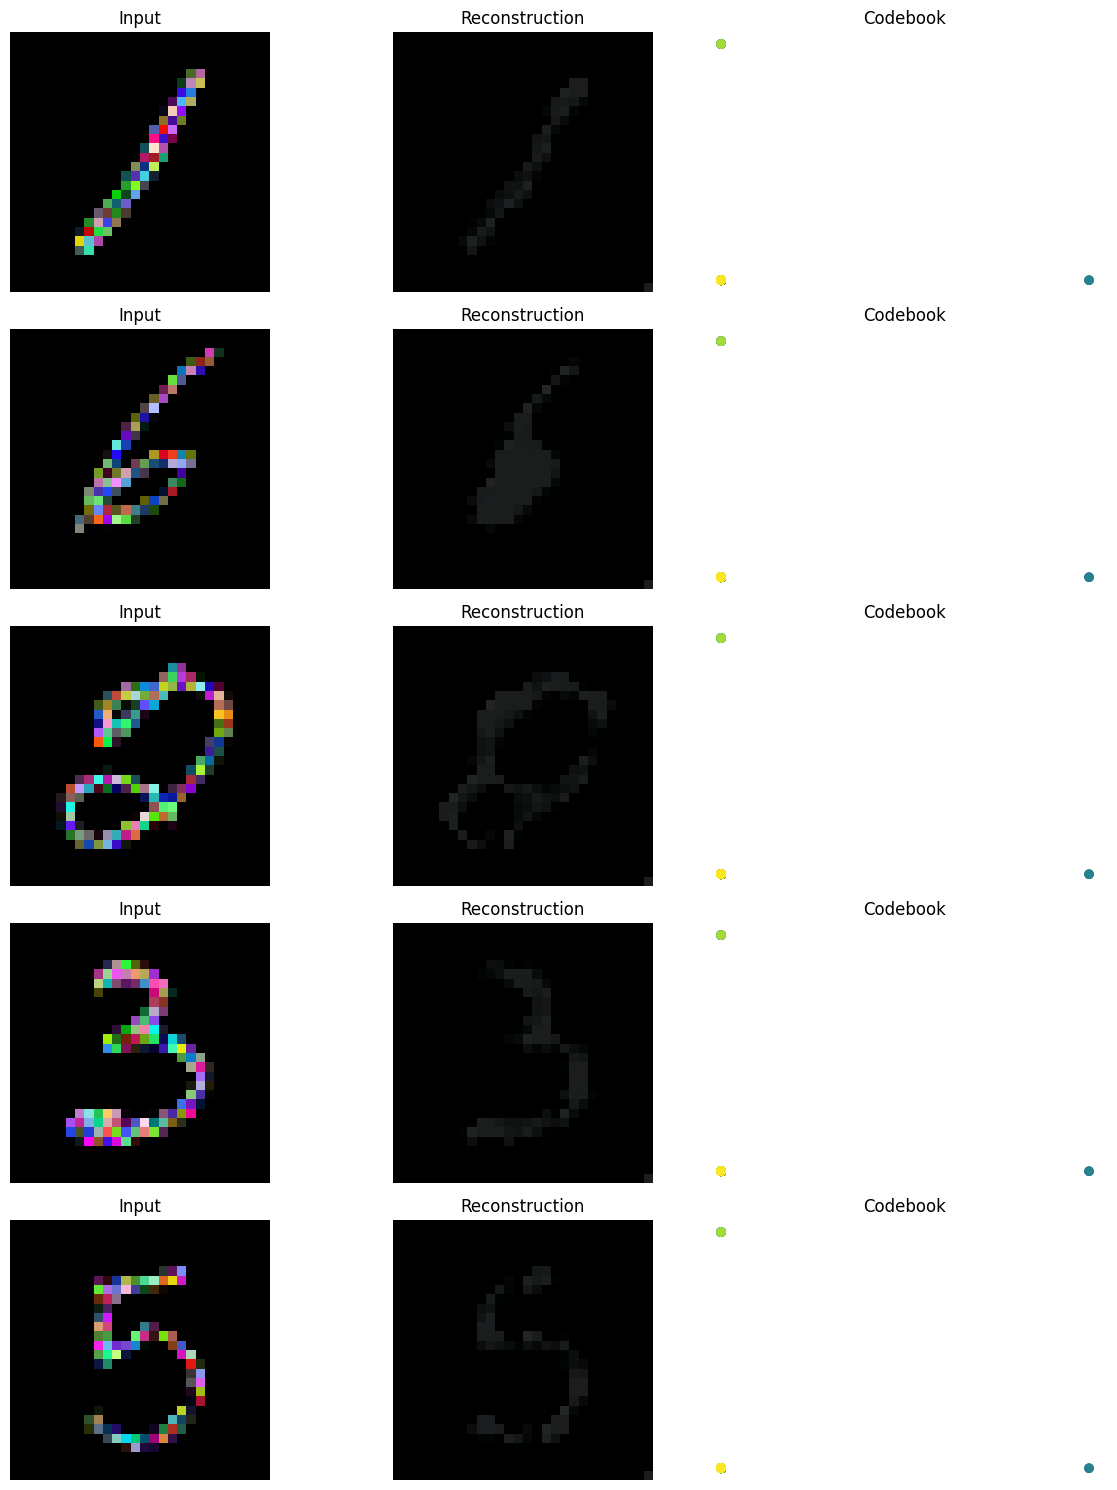

In [23]:
model2 = Model(num_hiddens=3, num_residual_layers=2, num_residual_hiddens=32, num_embeddings=50,
              embedding_dim=3, commitment_cost=0.25, decay=0.8)

file_name_rgb = 'gif_rgb2'
train_model_rgb(model2, train_loader_rgb, device, num_training_updates, learning_rate, data_variance, file_name_rgb)

# Visualize samples for the RGB dataset
visualize_samples(model2, val_loader_rgb, device, num_samples=5, plot_codebooks=True)

# Conclusion: 
As we observe, by increasing the dimensionality of the codebooks, the reconstruction loss increases, but the vector quantization loss decreases.
